In [1]:
import os
import cv2
import numpy as np

def load_data():
  base_folder = 'iNaturalist'
  toxic_folder = f'{base_folder}/toxic_images'
  nontoxic_folder = f'{base_folder}/nontoxic_images'

  toxic_paths = [os.path.join(dp, f) for dp, dn, filenames  in os.walk(toxic_folder) for f in filenames if os.path.splitext(f)[1] == '.jpg']
  nontoxic_paths = [os.path.join(dp, f) for dp, dn, filenames in os.walk(nontoxic_folder) for f in filenames if os.path.splitext(f)[1] == '.jpg']

  toxic_imgs = [cv2.imread(path) for path in toxic_paths]
  nontoxic_imgs = [cv2.imread(path) for path in nontoxic_paths]

  return toxic_imgs, nontoxic_imgs


data = load_data()

In [2]:
toxic_imgs, nontoxic_imgs = data
IMG_SHAPE = (224, 224, 3)
prepared_toxic_imgs = np.array([cv2.resize(img, IMG_SHAPE[:2]) for img in toxic_imgs])
prepared_nontoxic_imgs = np.array([cv2.resize(img, IMG_SHAPE[:2]) for img in nontoxic_imgs])

In [4]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

toxic_labels = np.array([[1, 0] for _ in range(len(prepared_toxic_imgs))])
nontoxic_labels = np.array([[0, 1] for _ in range(len(prepared_nontoxic_imgs))])

X = np.vstack((prepared_toxic_imgs, prepared_nontoxic_imgs))
y = np.vstack((toxic_labels, nontoxic_labels))

X, y = shuffle(X, y, random_state=42)
y = np.argmax(y, axis=1)

# Split the data into temporary and testing (combined test/validation) sets
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.105, random_state=42)

# Split the temporary set into the actual test and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.12, random_state=42)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape)


(2724, 224, 224, 3) (2724,) (364, 224, 224, 3) (364,) (372, 224, 224, 3) (372,)


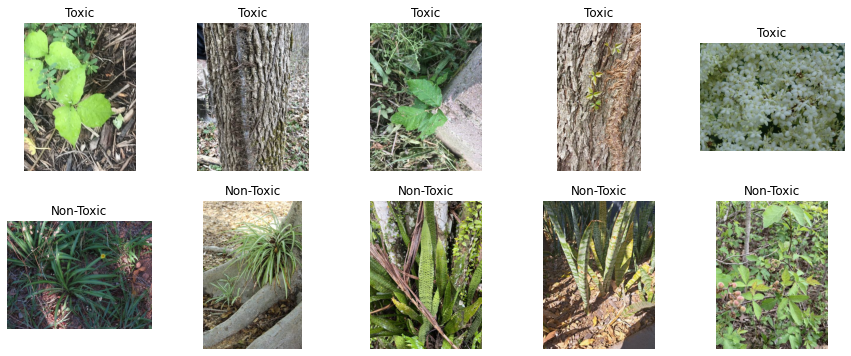

In [5]:
import random
import matplotlib.pyplot as plt

def display_random_images(toxic_imgs, nontoxic_imgs, num_toxic=5, num_nontoxic=5):
    random_toxic_imgs = random.sample(toxic_imgs, num_toxic)
    random_nontoxic_imgs = random.sample(nontoxic_imgs, num_nontoxic)

    plt.figure(figsize=(15, 6))

    for i, img in enumerate(random_toxic_imgs):
        plt.subplot(2, 5, i + 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title('Toxic')
        plt.axis('off')

    for i, img in enumerate(random_nontoxic_imgs):
        plt.subplot(2, 5, num_toxic + i + 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title('Non-Toxic')
        plt.axis('off')

    plt.show()

# Use the function to display 5 toxic and 5 non-toxic images
display_random_images(toxic_imgs, nontoxic_imgs, num_toxic=5, num_nontoxic=5)


In [8]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# Reshape the image data for training and testing
X_train_flattened = X_train.reshape(X_train.shape[0], -1)
X_test_flattened = X_test.reshape(X_test.shape[0], -1)

# Then proceed with the rest of your code, using the flattened data
param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [0.0001, 0.001, 0.1, 1], 'kernel': ['rbf', 'poly']}
svc = svm.SVC(probability=True)
model = GridSearchCV(svc, param_grid)

print('Split Successfully')
model.fit(X_train_flattened, y_train)  # Fit the model with the flattened image data

Split Successfully


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Predict using the best model from GridSearchCV
y_pred = model.predict(X_test_flattened)

# Evaluate the predictions
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
print("Confusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred)

ax= plt.subplot()
sns.heatmap(conf_matrix, annot=True, fmt='g', ax=ax)  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')